In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import regex as re
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [2]:
mt = pd.read_csv('data/mangas.csv')
at = pd.read_csv('data/animes.csv')
print(mt.shape, at.shape)
mt.head() #Recall that I didn't initially grab Flairs. So, we have more nulls than what's to be expected in general.

(5555, 7) (5655, 7)


,title,selftext,over_18,subreddit,time,id,flair
0,Y'all Know What This Font Is? \\ Kagurabachi c...,NaN,False,manga,1.705890e+09,19cko5o,NaN
1,Trying to find a manhwa/manhua but I cant reme...,I am trying to find a manga where the mc is a...,False,manga,1.705889e+09,19ckgrg,NaN
2,[DISC] Tower of God - Season 3 Episode 178,NaN,False,manga,1.705889e+09,19ckf2s,NaN
3,[ART] - Tatsuya Endo's illustration for Chapte...,NaN,False,manga,1.705888e+09,19ck611,NaN
4,Is the artist from “sono mono nochi ni” the sa...,NaN,False,manga,1.705888e+09,19ck1j5,NaN


In [3]:
at.head() #Oh, that's awkward.... must have messed up with my syntax when importing. 
#Anyways, that's obviously a mistake. Furthermore, I base my mistaken on not only the first entry's title... but domain 
#knowldge with the fourth (as that is/was airing at the time of the pull). Plus, I just googled the first one's id and 
# it's in R/anime...

,title,selftext,over_18,subreddit,time,id,flair
0,Having trouble finding Anime to watch with my ...,I started her with Death Note cause she loves ...,False,manga,1.705894e+09,19cm3ep,NaN
1,Yuuki Bakuhatsu Bang Bravern (Bang Brave Bang ...,NaN,False,manga,1.705893e+09,19cls7i,NaN
2,waifu 3x3. lets start a war!,[my 3x3 no order](https://imgur.com/a/nXsWUai)...,False,manga,1.705893e+09,19clr6w,NaN
3,「Jaku-Chara Tomozaki-kun 2nd STAGE」WEB Preview...,NaN,False,manga,1.705893e+09,19cln1f,NaN
4,My Thoughts on season 1 of hibike euphonium.,These are my thoughts on season 1 without the ...,False,manga,1.705893e+09,19clmrv,NaN


In [5]:
#Note, on that topic is something quite interesting - the timing of things. Likely this is true for all matters and discussions,
#but there is often a preference to discuss whatever is new. Perforce, with other data, albit not provided for us,
#one could trace 'current events' to posts. Ie it makes a lot of sense for 'Jakua-Chara Tomozaki-kun'/'Bottom-tier
#Tomozaki' to be discussed as the new anime season just came out two weeks ago. Now, likely that will bring with it
#revived interest in the manga,but pragmatically....

#And, on that topic: lower numbers are potentially more significant to animes as often the number of seasons with each one
#are lower than the accompany 'comic-book' like format associated with manga [conversion rates vary, but for
#an incredibly rough translation let's say 3ish (domain knowledge)]. Interestingly, a 2-gram might not pick this up as 'kun'
#is a Japanese honorific for a younger male (generally), however 'Tomozaki-2nd', or the current 3-gram of
#'Tomozaki-kun-2nd' would be significant.... however that is only imbuing with it domain knowledge - which the computer
#does not have.

In [4]:
at['subreddit'] = 'anime'
at.head()

,title,selftext,over_18,subreddit,time,id,flair
0,Having trouble finding Anime to watch with my ...,I started her with Death Note cause she loves ...,False,anime,1.705894e+09,19cm3ep,NaN
1,Yuuki Bakuhatsu Bang Bravern (Bang Brave Bang ...,NaN,False,anime,1.705893e+09,19cls7i,NaN
2,waifu 3x3. lets start a war!,[my 3x3 no order](https://imgur.com/a/nXsWUai)...,False,anime,1.705893e+09,19clr6w,NaN
3,「Jaku-Chara Tomozaki-kun 2nd STAGE」WEB Preview...,NaN,False,anime,1.705893e+09,19cln1f,NaN
4,My Thoughts on season 1 of hibike euphonium.,These are my thoughts on season 1 without the ...,False,anime,1.705893e+09,19clmrv,NaN


So yeah, just from the head we see two interesting things:
The manga head is 4/5 nans in just the selftext... likely those are pictures that we do not wish to explore for this
iteration of the project. We'll do a count momentarily.
Secondly, we already see a lot of Japanese.... besides the language gap, despite my experience, there will be not only
so many more stop words, but will likely be now so many more proper names, many of whom not capitalized, to make noise.
Thirdly, somewhat tangentially, will be spelling errors...
Fourthly will be the treatment of numbers... potentially relevant to certain things, likely in combination with things
ie episode... and alredy note in the third entry - we alrady have language that belongs to do 'anime' section seemingly...
    On the topic, we will need to be wary of emojis,etc... pragmatically we'll likely have enough data to just ignore them.

Pragmatically, we'll need to use Google translator a lot... for my sake and for the reader. But, for now, let us continue.

In [8]:
mt.isnull().sum() #Thankfully just the self text... but wow... over half in manga's text are just imagines...
#Yeah, at least in this subreddit very glad we'll be banking on the comments.

#Tangential: Back in the day when I ran comments, apparently no nulls in the 10kish manga comments... perhaps only the
#poster is able to make images and the like... I am unsure.

title           0
selftext     2981
over_18         0
subreddit       0
time            0
id              0
flair        2944
dtype: int64

In [9]:
at.isnull().sum() #Oh, this is interesting - much less nulls in the anime section... Besides having more words
#likely a difference in the two very similar things...

title           0
selftext      823
over_18         0
subreddit       0
time            0
id              0
flair        1010
dtype: int64

In [5]:
#Fine, let's do it, check for duplicates:
print(mt[mt['id'].duplicated()]['subreddit'].value_counts())
print(at[at['id'].duplicated()]['subreddit'].value_counts())
#Oooh, that's tough to see... 782 duplicates.... Well, recall that we can still keep a unique value
#from them, so we'd still probably have 3200... let's do just that.
#Oh wait, I'm way overthinking this - let's just use unique...

subreddit
manga    711
Name: count, dtype: int64
subreddit
anime    1104
Name: count, dtype: int64


In [6]:
print(len(mt['id'].unique()))
print(len(at['id'].unique()))

4844
4551


In [7]:
mt = mt.drop_duplicates(subset=['id'])
at = at.drop_duplicates(subset=['id'])

In [9]:
#Might at well use all the animes and trim off the extra mangas. Assuming that their order doesn't matter; nah, let's be thorough:
mt = mt.sample(frac=(at.shape[0]/mt.shape[0]), random_state=26)
mt.shape[0]

4551

In [10]:
#Anyways, we'll be adding the title to them all, so let's go ahead and combine them:
df = pd.concat([mt, at])
df = df.reset_index(drop=True)
#df.drop(['index'], axis = 1)
print(df.shape)
#Anyways, we now have our total anime and manga table. We'll do a bit more EDA then continue.
df.head()

(9102, 7)


,title,selftext,over_18,subreddit,time,id,flair
0,[DISC] Lying Brides and Same-Sex Marriage Theo...,NaN,False,manga,1.707316e+09,1al3zwm,DISC
1,help finding a manga,hi guys im literally going crazy trying to fin...,False,manga,1.706583e+09,1aee2m5,NaN
2,[DISC] Daredemo Dakeru Kimi ga Suki - Ch. 29 -...,NaN,True,manga,1.707195e+09,1ak1l0c,DISC
3,"[Art] - ""Smoking Behind the Supermarket With Y...",NaN,False,manga,1.706111e+09,19ejyc8,ART
4,[DISC] The Knight King Who Returned with a God...,NaN,False,manga,1.707007e+09,1aiaq4a,DISC


In [11]:
df.isnull().sum()  #Unsuprisingly high amounts of flair nulls, as we didn't correct them in our original data pulls.
#Plus, a lot of the other pulls were just nulls... 

title           0
selftext     3064
over_18         0
subreddit       0
time            0
id              0
flair        3417
dtype: int64

In [12]:
df['over_18'].value_counts(normalize=True) #Might be fun to look into, but for now we'll just be focusing on the main text.
#Potentially finally flair in this iteration of the project.

over_18
False    0.966601
True     0.033399
Name: proportion, dtype: float64

In [13]:
df.groupby('subreddit')['over_18'].sum() #Interesting dichotamy. Then again, likely more regulation over TV. Heh, could
#think of a few fun examples already where the anime was waaaay toned down over the manga.

subreddit
anime     53
manga    251
Name: over_18, dtype: int64

In [14]:
df.groupby('subreddit')['flair'].count()#Hmm, another interesting thing. Honestly upon thinking about it more, the over18
#albeit rare, is a sign that likely it's probably manga.... for sure tipping that in with other factors.

#And now, we see a much greater proporton of flairs in anime than manga, regardless of what the flair evn is.
#On the topic, might be worthwhile to then combine flair into the main self text for analysis....
#or maybe keep it separate. Regardless, the presence of a flair is also more likely to make a post be identified as anime.

#And again, recall how albeit the first few posts I did not pull flair - THAT APPLIED TO BOTH OF THEM. Truthfully, I

subreddit
anime    3641
manga    2044
Name: flair, dtype: int64

In [15]:
#Yeah, look below - while over half of the mangas are null, only 15% of animes are. See below.
print(df[df['subreddit']=='manga']['selftext'].isnull().sum(), df[df['subreddit']=='manga']['selftext'].isnull().sum()/df[df['subreddit']=='manga']['selftext'].isnull().count())
print(df[df['subreddit']=='anime']['selftext'].isnull().sum(), df[df['subreddit']=='anime']['selftext'].isnull().sum()/df[df['subreddit']=='anime']['selftext'].isnull().count())

2420 0.5317512634585805
644 0.14150736101955613


## Deciding the NLP Target

Bottom line, the current decision is to make a new column, joining together title, assuming significace in that (plus a way
to deal with all of those nulls...). Note that we will do this to all things, as all posts have a title [likly].
Pragmatically, when we later look at average word count, albeit not counting images and the like, we'd expect manga
to be less [a bit ironic considering it's the written version...].

In [16]:
df = df.fillna("")
df['post'] = df['title'] + " " + df['selftext']
df.head()

,title,selftext,over_18,subreddit,time,id,flair,post
0,[DISC] Lying Brides and Same-Sex Marriage Theo...,,False,manga,1.707316e+09,1al3zwm,DISC,[DISC] Lying Brides and Same-Sex Marriage Theo...
1,help finding a manga,hi guys im literally going crazy trying to fin...,False,manga,1.706583e+09,1aee2m5,,help finding a manga hi guys im literally goin...
2,[DISC] Daredemo Dakeru Kimi ga Suki - Ch. 29 -...,,True,manga,1.707195e+09,1ak1l0c,DISC,[DISC] Daredemo Dakeru Kimi ga Suki - Ch. 29 -...
3,"[Art] - ""Smoking Behind the Supermarket With Y...",,False,manga,1.706111e+09,19ejyc8,ART,"[Art] - ""Smoking Behind the Supermarket With Y..."
4,[DISC] The Knight King Who Returned with a God...,,False,manga,1.707007e+09,1aiaq4a,DISC,[DISC] The Knight King Who Returned with a God...


In [17]:
#Tangential to our current step, but I can't resist:
df['over_18'] = df['over_18'].astype(int)
print(df['over_18'].value_counts(normalize=True))
print(df.groupby('subreddit')['over_18'].describe()) #Interestingly an almost 1:4 ratio between the two. Of also interest
#is the general discrepency between images/text (see below after our basic post cleaning).

over_18
0    0.966601
1    0.033399
Name: proportion, dtype: float64
            count      mean       std  min  25%  50%  75%  max
subreddit                                                     
anime      4551.0  0.011646  0.107297  0.0  0.0  0.0  0.0  1.0
manga      4551.0  0.055153  0.228303  0.0  0.0  0.0  0.0  1.0


In [18]:
#Anyways, that reminds me to do the same integerizing to our subreddit:
df['subreddit'] = df['subreddit'].map(dict(anime=1, manga=0))
df['subreddit'].value_counts(normalize=True)

subreddit
0    0.5
1    0.5
Name: proportion, dtype: float64

## Cleaning Time

I thought a lot about the following, but bottom line I insist on doing a bit of cleaning now:

In [19]:
#Hmm, let's start by breaking apart the comments, trying to get an aveage word count...
def document_words(raw_document):

    #Remove some various html hiccups that may have crept in.
    document_text = BeautifulSoup(raw_document).get_text()
    
    #Further purge it via regex to keep only characters per Regex. For sure in this case I'm keeping numbers
    letters_only = re.sub("[^a-zA-Z0-9]", " ", document_text)
    #Convert to lower case, split into individual words.
        #Note that potentially '[' and the like should have been kept to delient flairs... oh well
    
    #Re. lowercasing: I have a string feeling we'll be seeing a lot of acronyms, that will hopefully be capitalized.
    #So, we'll leav this alone... Perhaps do some regex later/go back and rerunthis, but for at least an initial look...
    #words = letters_only.lower().split()
    #Note, that we've already alluded to potential concerns. re spelling - not only in Englsih but now we might have
    #to be wary of Japanse spelling errors... Furthermore, potential misclassification via capitlzation discrepencies.
    #Regardless... Oh, what we could do is make regex code for if it's just capital letters keep it... HMm... Yeah
    #Let's do that.
    
    #Note, the regex I'd need should be as follows: /[A-Z]{2,}/gm... Yeah, this might get tricky with Regex... Let's
    #make this simple and more user-friendly, albeit likely only a technical audience is reading all this:
    
    #Again, in retrospect maybe it would be recognizable...
    #but in case a word's acrnoym is a stopword ie if 'FOR' means something... would otherwise get lost...
    #Note, and likely redundant by now and the reader gets the point, but we'd still have to be wary of people lowercasing
    #an acrnonym...
    
    #Note, the regex I'd need should be as follows: /[A-Z]{2,}/gm
    
    #The following should be what I want. Might even keep this for other cases...
    
    words = letters_only.split()
    words = [w if w.isupper() else w.lower() for w in words]
    
    #AFTER, thinking about matters, I decided to leave stopwords to hyperparamter tuning, as perhaps certain
    #eddits don't spell... For now we'll keep stemming though.
    
    #Removing stopwords per my default policy of keeping things simple. Note that we may need to go back
    #to this and certain key English words in this domain might matter. Furthermore, we'll need to be wary of Japanese
    #stop words. Ie we already see one in the first comments - 'Monster Musume no Iu Nichijou' translate to
    #'Everyday Life with a Monster Girl' where 'no' in Japanese roughly translates to 'of', context dependent as we
    #see already. In this example the two stop words would overlap. Pragmatically, there may be an example I'm not sure
    #of, but you never know...
    
    #stops = set(stopwords.words('english'))#Note that I did see something about J. stop words.
    #meaningful_words = [w for w in words if w not in stops]
        #Hmm, I wonder if I should worry about 1 letter capital words... eh, at most 26... then I....
    
    #Stemming words... Hmm. Generally I am a big believer in stemming, but when dealing with another language I am
    #a bit more hesitant. As a default we'll go with it.
        #After completing the 'project' for the first time, in retrospect I think it would be important to experiment
        #with not neccesarily stemming everything - especially when ultimately we deal with titles and have a much
        #smaller base of words to experiment with, as opposed to the original ocean called posts.
    p_stemmer = PorterStemmer()
    stemmed_words = [p_stemmer.stem(i, to_lowercase=False) for i in words]
    
    #Note, that although it may proove worthwhile to lemmatize and retain more features, as lemmatization only lightly
    #trims words, I prefer the more reductionalist result of stemming to cut down even more words to represent many.
    
    #And finally, let us merge back everything to a new document.
    return(" ".join(stemmed_words))

In [20]:
 df['cleaned_post'] = df['post'].apply(document_words)

C:\Users\bwolf\AppData\Local\Temp\ipykernel_17468\2532007743.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  document_text = BeautifulSoup(raw_document).get_text()


In [21]:
 df['cleaned_title'] = df['title'].apply(document_words) #With present time obligations, I doubt I will explore this, but
#hopefully in the future. See below when we examine word length.

C:\Users\bwolf\AppData\Local\Temp\ipykernel_17468\2532007743.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  document_text = BeautifulSoup(raw_document).get_text()


In [22]:
df.head()

,title,selftext,over_18,subreddit,time,id,flair,post,cleaned_post,cleaned_title
0,[DISC] Lying Brides and Same-Sex Marriage Theo...,,0,0,1.707316e+09,1al3zwm,DISC,[DISC] Lying Brides and Same-Sex Marriage Theo...,DISC lie bride and same sex marriag theori cha...,DISC lie bride and same sex marriag theori cha...
1,help finding a manga,hi guys im literally going crazy trying to fin...,0,0,1.706583e+09,1aee2m5,,help finding a manga hi guys im literally goin...,help find a manga hi guy im liter go crazi tri...,help find a manga
2,[DISC] Daredemo Dakeru Kimi ga Suki - Ch. 29 -...,,1,0,1.707195e+09,1ak1l0c,DISC,[DISC] Daredemo Dakeru Kimi ga Suki - Ch. 29 -...,DISC daredemo dakeru kimi ga suki ch 29 remind...,DISC daredemo dakeru kimi ga suki ch 29 remind...
3,"[Art] - ""Smoking Behind the Supermarket With Y...",,0,0,1.706111e+09,19ejyc8,ART,"[Art] - ""Smoking Behind the Supermarket With Y...",art smoke behind the supermarket with you colo...,art smoke behind the supermarket with you colo...
4,[DISC] The Knight King Who Returned with a God...,,0,0,1.707007e+09,1aiaq4a,DISC,[DISC] The Knight King Who Returned with a God...,DISC the knight king who return with a god cha...,DISC the knight king who return with a god cha...


In [24]:
i = -1

In [32]:
i +=1
print(df['title'][i])
print(df['cleaned_title'][i]) #Just doing a bit of a before and after:

[NEWS] 2023 oneshot “Bug Ego” from ONE & Kiyoto Shitara serialization announced
NEWS 2023 oneshot bug ego from ONE kiyoto shitara serial announc


In [ ]:
#Remember that 'post' represents the 'complete' post of the user, combining their post's title and body.
i +=1
print(df['post'][i])
print(df['cleaned_post'][i])

In [33]:
#Go time for word_counting
df['word_count_post'] =  df['cleaned_post'].str.split().str.len()
df['word_count_title'] =  df['cleaned_title'].str.split().str.len()

In [34]:
df['word_count_post'].describe() #Very nice... I'm unsure what's typical, but this is looking well so far.
#Notice something quite interesting: the mean is almost double the median! And, we can tell the max post is quite big...
#a potential outlier to get rid of, but for now.

count    9102.000000
mean       81.515931
std       177.505694
min         0.000000
25%        12.000000
50%        46.000000
75%        94.000000
max      6397.000000
Name: word_count_post, dtype: float64

In [35]:
print(df[df['word_count_post'] < 12]['subreddit'].value_counts(normalize=True)) #See below.
print(len(df[df['word_count_post'] < 12]['subreddit']))

subreddit
0    0.797434
1    0.202566
Name: proportion, dtype: float64
2182


In [44]:
df.groupby('subreddit')['word_count_post'].describe() #Overall unsurprisingly given how many more nulls there were in
#manga and pragmatically the main post would be longer than the title. Hence, the discrepency between
#the medians - as the median manga's word count was only generated from its title!
#Note that if you factor out the title and replace a picture [that's supposed to be worth a 'thousand words'] with 50-60
#words, both the mean and median of manga posts approximate anime posts' length. Perhaps something true of all subreddits, or
#at least these two domains... Regardless, we continue.

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
0,4551.0,50.056032,131.886952,0.0,8.0,17.0,62.0,3422.0
1,4551.0,112.975829,208.924422,4.0,38.0,68.0,131.0,6397.0


In [38]:
df.groupby('subreddit')['word_count_title'].describe() #Now, see something far more even - on the sole basis of word
#count in the titles [albeit after our scrubbing] the medians and third quadrants are the same. We have similar means and
#first quartile values. Although we see greater values across the fields for animes, they are not so distant as we noticed
#earlier with the "posts" which for manga was mostly relying on titles.

#Also note the 'outliers' of both. Eh, look at the boxplot below to confirm visually, but considering how they both follow
#such a trend I am completly unconcened.

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
0,4551.0,9.149637,5.937312,0.0,5.0,8.0,11.0,60.0
1,4551.0,9.412876,5.671661,3.0,6.0,8.0,11.0,59.0


In [39]:
df[df['selftext'] == '']['subreddit'].value_counts()  #So, for ultimately 2420 of the mangas we are relying on their
#titles; a mere 30ish percent of that is true for animes.

subreddit
0    2420
1     644
Name: count, dtype: int64

Per the new data that has been gathered, I honestly did not even think to bother to check for the followng until I got an error in the modeling:

In [46]:
df.isnull().sum()

title               0
selftext            0
over_18             0
subreddit           0
time                0
id                  0
flair               0
post                0
cleaned_post        0
cleaned_title       0
word_count_post     0
word_count_title    0
dtype: int64

In [51]:
df.iloc[1154][['cleaned_post', 'cleaned_title']]

cleaned_post     
cleaned_title    
Name: 1154, dtype: object

In [55]:
df.iloc[1154][['title','selftext']] #Hmm, so we have some Russian.... or another Slavic language...

title       Какого персонажа сериала/ фильма/ аниме/ мульт...
selftext                       Интересно узнать ваше мнение:)
Name: 1154, dtype: object

In [53]:
df.iloc[3881][['cleaned_post', 'cleaned_title']]

cleaned_post     brother and sister in thi holi art I seem to h...
cleaned_title                                                     
Name: 3881, dtype: object

In [56]:
df.iloc[3881][['title','selftext']] #Hmm, yeah, that's some text editing right there... Eh, I won't bother. We still have over 9k...

title       𝕱𝖊𝖑𝖑𝖔𝖜 𝕯𝖆𝖔𝖎𝖘𝖙𝖘, 𝕳𝖊𝖑𝖕 𝖒𝖊 𝕽𝖊𝖒𝖊𝖒𝖇𝖊𝖗 𝖙𝖍𝖎𝖘 𝖋𝖔𝖗𝖌𝖔𝖙𝖙𝖊...
selftext     Brothers and sisters in this holy art, I seem...
Name: 3881, dtype: object

In [57]:
df = df.drop([1154,3881]) #And seemingly this reset the index too. Fine, let's keep going

In [59]:
df['subreddit'].value_counts() #Hmm, right now an even 9100.... Yeah, I'll keep it like this. Plus pragamtically they're the same...

subreddit
1    4551
0    4549
Name: count, dtype: int64

In [62]:
#I suppose before we start modeling we'll export our cleaned data [and also start working in a fresh notebook].

# df.to_csv('data/cleaned_reddits.csv', index = False)

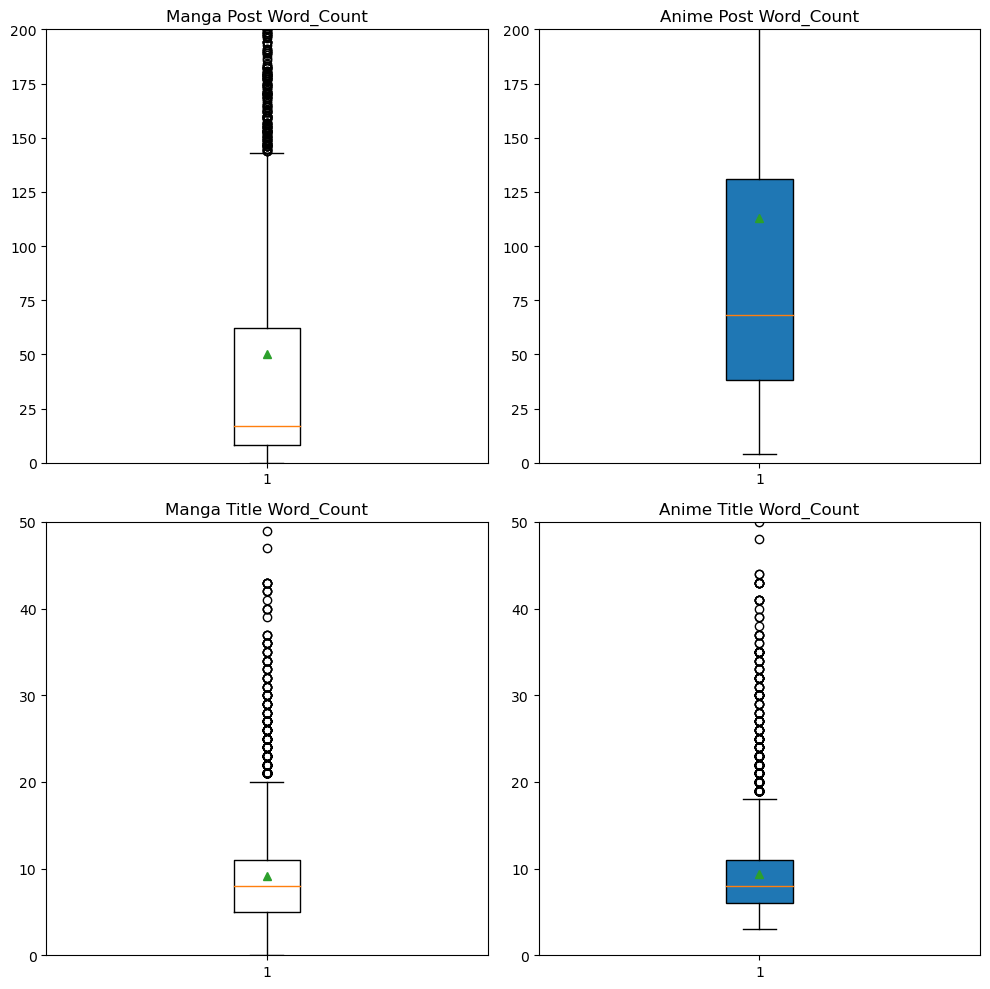

In [41]:
#Since the following is really from the EDA stage, I feel like I'll make the graphs for the word count post/titles here:
plt.figure(figsize=(10, 10))

ax1 = plt.subplot(2,2,1)
ax1.boxplot(df[df['subreddit'] ==0]['word_count_post'], showmeans=True)
ax1.set_ylim(0, 200)
ax1.set_title("Manga Post Word_Count")

ax2 = plt.subplot(2,2,2)
ax2.boxplot(df[df['subreddit'] ==1]['word_count_post'], showmeans=True, patch_artist=True)
ax2.set_ylim(0, 200)
ax2.set_title("Anime Post Word_Count")

ax3 = plt.subplot(2,2,3)
ax3.boxplot(df[df['subreddit'] ==0]['word_count_title'], showmeans=True)
ax3.set_ylim(0, 50)
ax3.set_title("Manga Title Word_Count")

ax4 = plt.subplot(2,2,4)
ax4.boxplot(df[df['subreddit'] ==1]['word_count_title'], showmeans=True, patch_artist=True)
ax4.set_ylim(0, 50)
ax4.set_title("Anime Title Word_Count")

plt.tight_layout();

In [ ]:
df['cleaned_post']